### Final Report (Group #36)

In [321]:
# Load the packages and set the seed

library(tidyverse)
library(repr)
library(tidymodels)
library(dplyr)
library(GGally)

options(repr.matrix.max.rows = 6)
set.seed(999) 

### _INTRO:_


**Our Predictive Question :  Can age, resting blood pressure, cholestoral levels, and maximum heart rate achieved accurately predict the diagnosis of heart disease?**

Heart disease is an increasingly prevalent condition affecting a multitude of different people globally. Heart disease refers to a multitude of different heart conditions such as coronary artery disease and cardiomyopathy ("About Heart Disease", 2022). These debilitating conditions contribute annually to 1 in 4 American deaths every year (2022), making prompt diagnosis and treatment of these conditions of grave importance. Though the onset of these conditions vary, generally there are certain risk factors which can contribute to a heart disease diagnosis. These factors can include high blood pressure, physical inactivity, and high blood cholesterol (2022). Understanding these risk factors and finding individuals who may have them could lead to a more prompt diagnosis of these diseases and thus more effective treatment.

Our project aims to investigate if age, resting blood pressure, cholesterol levels and maximum heart rate of an individual can be predictors of a heart disease diagnosis. In understanding the predictive ability of these two variables more reliable diagnosis options can be explored to help patients before the onset of debilitating heart disease. 

The data set we will use to explore this predictive problem is a compiled heart disease data set from Kaggle.com. This data set contains information on multiple onset heart disease risk factors of individuals admitted to the hospital for acute chest pain with patient data from 4 different global locailites spanning from 1988 onwards. This data set includes information about the age, sex, cheat pain type (from 0-4), the resting blood pressure, serum cholestoral level in the blood, the fasting blood sugar, the maximum heart rate achieved, the presence of exercise induced angina, the number of major vessels (from 0-3). and the diagnosis of the blood disorder thalassemia with 0 as normal, 1 as fixed defect and 2 as reversible defect. Additionally, there is data about results of electrocardiogram tests including the resting electrocardiographic results (values 0-2), the ST depression value and the slope of the ST segment, Lastly, there is data on the presence of heart disease in the patient with 0 indicating no disease and 1 indicating the presence of heart disease. 


### _Methods/Results:_ 

We will be using the KNN Classification to predict the presence of heart disease

**1) Loading our data: Required packages and the dataset and do adjustments to dataset, Set the seed (above) to have consistent randomness**

**2) Split the dataset into training/testing data: initial_split() to create the sets**

**3) Explore/Visualize the data through scatter plots**

**4) Tuning the model: For best K value, tune the model using a 5-fold cross validation method on the training set then plot accuracy vs # of neighbors**

**5) K-nearest neighbor classification: Use the highest K found to test our model on the testing set by predicting it**

**6) Result analysis: Add the column of predictions to the original test data & create a confusion matrix then Calculate accuracy**

**7) Review our model/goal/report**

In [322]:
url <- "https://raw.githubusercontent.com/sadia-kd/DSCI-Project/main/heart.csv"

heart_disease <- read_csv(url) %>%
    mutate(target = as_factor(target)) %>%
    unique() %>%
    select(age, trestbps, chol, thalach, target)

heart_disease

Parsed with column specification:
cols(
  age = col_double(),
  sex = col_double(),
  cp = col_double(),
  trestbps = col_double(),
  chol = col_double(),
  fbs = col_double(),
  restecg = col_double(),
  thalach = col_double(),
  exang = col_double(),
  oldpeak = col_double(),
  slope = col_double(),
  ca = col_double(),
  thal = col_double(),
  target = col_double()
)



age,trestbps,chol,thalach,target
<dbl>,<dbl>,<dbl>,<dbl>,<fct>
52,125,212,168,0
53,140,203,155,0
70,145,174,125,0
⋮,⋮,⋮,⋮,⋮
52,128,255,161,0
59,160,273,125,0
54,120,188,113,0


### Explore The Data

In [323]:
# spliting the data intro training set 

heart_disease_split <- initial_split(heart_disease, prop = 0.75, strata = target)
heart_disease_train <- training(heart_disease_split)
heart_disease_test <- testing(heart_disease_split) 

In [324]:
# Summarize the training DATA 

obs <- nrow(heart_disease_train)

data_count <- heart_disease_train %>%
    group_by(target) %>%
    summarize(count = n(), percentage = n()/obs * 100)

data_count

`summarise()` ungrouping output (override with `.groups` argument)



target,count,percentage
<fct>,<int>,<dbl>
0,104,45.81498
1,123,54.18502


In [325]:
sum(is.na(heart_disease_train))

[1] 0

In [326]:
summary(heart_disease_train)

      age          trestbps        chol          thalach      target 
 Min.   :29.0   Min.   : 94   Min.   :131.0   Min.   : 71.0   0:104  
 1st Qu.:48.0   1st Qu.:120   1st Qu.:211.5   1st Qu.:133.0   1:123  
 Median :56.0   Median :130   Median :244.0   Median :153.0          
 Mean   :54.7   Mean   :132   Mean   :249.1   Mean   :150.0          
 3rd Qu.:61.0   3rd Qu.:140   3rd Qu.:279.5   3rd Qu.:166.5          
 Max.   :77.0   Max.   :200   Max.   :564.0   Max.   :202.0          

### Visualization below here ...

### _Performing the Analsyis_

In [327]:
# Set the seed. Don't remove this!
set.seed(999) 

# We have already selected the specific columns we will need ONLY in the beginning when loading the data

# Begin with creating the model (tuning it), Preprocessing the data 

heart_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = tune()) %>%
        set_engine("kknn") %>%
        set_mode("classification")

heart_recipe <- recipe(target ~. , data = heart_disease_train) %>%
        step_scale(all_predictors()) %>%
        step_center(all_predictors())

In [328]:
# Set the seed. Don't remove this!
set.seed(999)

# Create the 5-fold cross-validation on the training set

vfold <- vfold_cv(heart_disease_train, v = 5, strata = target)

# Create a data frame with a neighbors variable that contains the sequence of values of K to try. 
# Containing values from 1 to 100 (stepping by 5)

k_vals <- tibble(neighbors = seq(from = 1, to = 100, by = 5))

In [329]:
# Set the seed. Don't remove this!
set.seed(999)

# Putting it in a workflow

heart_disease_workflow <- workflow() %>%
        add_recipe(heart_recipe) %>%
        add_model(heart_spec) %>%
        tune_grid(resamples = vfold, grid = k_vals) %>%
        collect_metrics()
heart_disease_workflow

neighbors,.metric,.estimator,mean,n,std_err,.config
<dbl>,<chr>,<chr>,<dbl>,<int>,<dbl>,<chr>
1,accuracy,binary,0.5550856,5,0.01824251,Model01
1,roc_auc,binary,0.5515238,5,0.01510068,Model01
6,accuracy,binary,0.6126921,5,0.02337355,Model02
⋮,⋮,⋮,⋮,⋮,⋮,⋮
91,roc_auc,binary,0.7263929,5,0.01963163,Model19
96,accuracy,binary,0.6566623,5,0.02852401,Model20
96,roc_auc,binary,0.7237421,5,0.01811828,Model20


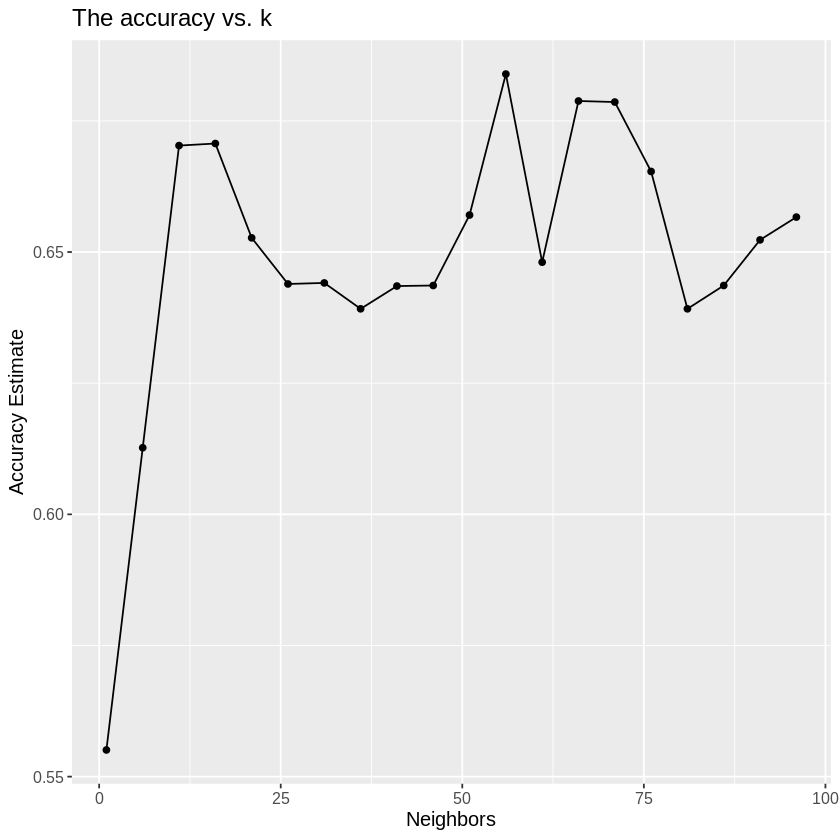

In [330]:
# Plot the 𝑘 vs the accuracy to determine which number of neighbors is best

accuracies <- heart_disease_workflow %>% 
        filter(.metric == "accuracy") 

accuracy_vs_k <- ggplot(accuracies, aes(x = neighbors, y = mean)) +
        geom_point() +
        geom_line() +
        labs(x = "Neighbors", y = "Accuracy Estimate") +
        theme(text = element_text(size = 12)) +
        ggtitle("The accuracy vs. k")

accuracy_vs_k

In [331]:
# Find the # Neighbors through data

k_accurate <- heart_disease_workflow %>% 
        filter(.metric == "accuracy") %>%
        arrange(mean) %>%
        tail(1) %>%
        pull(neighbors)

k_accurate

[1] 56

**The k-value which we found that provide the highest accurate model is 56, we will now use this and re-do our knn classification to predict our test set**

#### Build Our Model

In [332]:
# Set the seed. Don't remove this!
set.seed(999)

# use neighbors = 31
# create new model
# use the same recipe

best_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = 56) %>%
        set_engine("kknn") %>%
        set_mode("classification")

Knn_fit <- workflow() %>%
        add_recipe(heart_recipe) %>%
        add_model(best_spec)%>%
        fit(data = heart_disease_train)

Knn_fit

══ Workflow [trained] ══════════════════════════════════════════════════════════
Preprocessor: Recipe
Model: nearest_neighbor()

── Preprocessor ────────────────────────────────────────────────────────────────
2 Recipe Steps

● step_scale()
● step_center()

── Model ───────────────────────────────────────────────────────────────────────

Call:
kknn::train.kknn(formula = ..y ~ ., data = data, ks = ~56, kernel = ~"rectangular")

Type of response variable: nominal
Minimal misclassification: 0.339207
Best kernel: rectangular
Best k: 56

##### Predit the heart_disease_test set now

In [333]:
data_predicted <- predict(Knn_fit, heart_disease_test) %>%
        bind_cols(heart_disease_test) %>%
        metrics(truth = target, estimate = .pred_class) %>%
        filter(.metric == "accuracy")

data_predicted

.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
accuracy,binary,0.6933333
